In [3]:
import csv
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import os
from tqdm import tqdm

def calculate_properties(input_file, output_file):
    with open(input_file, 'r') as f:
        smiles_list = [line.strip() for line in f if line.strip()]

    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['SMILES', 'MW', 'TPSA', 'logP', 'QED']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for smi in smiles_list:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                mw = Descriptors.MolWt(mol)
                tpsa = Descriptors.TPSA(mol)
                logp = Descriptors.MolLogP(mol)
                qed = Descriptors.qed(mol)
                writer.writerow({'SMILES': smi, 'MW': mw, 'TPSA': tpsa, 'logP': logp, 'QED': qed})
            else:
                writer.writerow({'SMILES': smi, 'MW': None, 'TPSA': None, 'logP': None, 'QED': None})

def process_folder(input_folder, output_folder):
    """
    Process all SMILES files in the input folder and save results in the output folder.

    Args:
        input_folder (str): Path to the input folder containing SMILES files.
        output_folder (str): Path to the output folder to save CSV files.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    smi_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f)) and f.endswith('.smi')]

    for filename in tqdm(smi_files, desc="Processing folder"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename.replace('.smi', '.csv'))
        calculate_properties(input_path, output_path)

input_folder = '/Users/mac/Downloads/code/project/mol_opt/app/experiment/scaffold'
output_folder = '/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties'
process_folder(input_folder, output_folder)

Processing folder: 100%|██████████| 6/6 [07:34<00:00, 75.81s/it] 


In [10]:
import pandas as pd

def calculate_gkld(file_to_target_mapping: dict) -> dict:
    """
    Calculate GKLD for a set of files based on their respective target properties.

    Parameters:
        file_to_target_mapping (dict): Dictionary where keys are filenames (CSV) and values are
dictionaries of target properties (e.g., {'logP': 2, 'QED': 0.6}).

    Returns:
        dict: GKLD values for each file and comparison, structured as {filename: {"current": gkld1, "train": gkld2, "val": gkld3}}.
    """
    results = {}

    train_file = "/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties/train_100_scaffold.csv"
    val_file = "/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties/val_100_scaffold.csv"

    for file, target_properties in tqdm(file_to_target_mapping.items(), desc="Calculating GKLD"):
        result = {}

        # Load data for the current file
        data = pd.read_csv(f'//Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties/{file}')
        data_points = data[list(target_properties.keys())].values
        target_point = np.array(list(target_properties.values()))

        # Compute GKLD for the current file
        distances = np.sum((data_points - target_point) ** 2, axis=1)
        bandwidth = 0.1
        kernel = np.exp(-distances / (2 * bandwidth ** 2))
        result["current"] = np.mean(kernel)

        # Compute GKLD for the train file
        train_data = pd.read_csv(train_file)
        train_points = train_data[list(target_properties.keys())].values
        train_distances = np.sum((train_points - target_point) ** 2, axis=1)
        train_kernel = np.exp(-train_distances / (2 * bandwidth ** 2))
        result["train"] = np.mean(train_kernel)

        # Compute GKLD for the val file
        val_data = pd.read_csv(val_file)
        val_points = val_data[list(target_properties.keys())].values
        val_distances = np.sum((val_points - target_point) ** 2, axis=1)
        val_kernel = np.exp(-val_distances / (2 * bandwidth ** 2))
        result["val"] = np.mean(val_kernel)

        results[file] = result

    return results

FILE_TO_TARGET_MAPPING = {
    'train-qed-0d2-scaffold.csv': {'QED': 0.2},
    'val-logp-n4-scaffold.csv': {'logP': -4},
    'train-qed-0d4-scaffold.csv': {'QED': 0.4},
    'val-logp-n2-scaffold.csv': {'logP': -2},
    'val-qed-0d8-scaffold.csv': {'QED': 0.8},
    'train-tpsa-40-scaffold.csv': {'TPSA': 40},
    'val-logp-2-tpsa-40-scaffold.csv': {'logP': 2, 'TPSA': 40},
    'train-all-logp-300-80-3-0d7-scaffold.csv': {'logP': 3.0, 'TPSA': 80, 'QED': 0.7},
    'train-logp-2-tpsa-40-scaffold.csv': {'logP': 2, 'TPSA': 40},
    'train-logp-n4-scaffold.csv': {'logP': -4},
    'val-logp-4-scaffold.csv': {'logP': 4},
    'val-logp-4-tpsa-160-scaffold.csv': {'logP': 4, 'TPSA': 160},
    'val-qed-0d2-scaffold.csv': {'QED': 0.2},
    'val-tpsa-40-scaffold.csv': {'TPSA': 40},
    'val-logp-3-tpsa-100-scaffold.csv': {'logP': 3, 'TPSA': 100},
    'val-all-logp-250-140-2-0d6-scaffold.csv': {'logP': 2.0, 'TPSA': 140, 'QED': 0.6},
    'train-qed-0d8-scaffold.csv': {'QED': 0.8},
    'train-logp-n2-scaffold.csv': {'logP': -2},
    'val-logp-2-scaffold.csv': {'logP': 2},
    'val-qed-0d4-scaffold.csv': {'QED': 0.4},
    'val-all-logp-300-80-3-0d7-scaffold.csv': {'logP': 3.0, 'TPSA': 80, 'QED': 0.7},
    'val-qed-0d6-scaffold.csv': {'QED': 0.6},
    'train-logp-4-scaffold.csv': {'logP': 4},
    'train-tpsa-80-scaffold.csv': {'TPSA': 80},
    'train-tpsa-120-scaffold.csv': {'TPSA': 120},
    'train-tpsa-160-scaffold.csv': {'TPSA': 160},
    'train-logp-2-scaffold.csv': {'logP': 2},
    'train-qed-0d6-scaffold.csv': {'QED': 0.6},
    'val-tpsa-80-scaffold.csv': {'TPSA': 80},
    'val-tpsa-160-scaffold.csv': {'TPSA': 160},
    'train-all-logp-250-140-2-0d6-scaffold.csv': {'logP': 2.0, 'TPSA': 140, 'QED': 0.6},
    'val-tpsa-120-scaffold.csv': {'TPSA': 120},
    'train-logp-4-tpsa-160-scaffold.csv': {'logP': 4, 'TPSA': 160},
    'train-logp-3-tpsa-100-scaffold.csv': {'logP': 3, 'TPSA': 100},
}

gklb = calculate_gkld(FILE_TO_TARGET_MAPPING)
gklb

Calculating GKLD: 100%|██████████| 34/34 [00:00<00:00, 44.47it/s]


{'train-qed-0d2-scaffold.csv': {'current': 0.7745234210365622,
  'train': 0.03333628751059794,
  'val': 0.02314024925651928},
 'val-logp-n4-scaffold.csv': {'current': 0.19499806726879865,
  'train': 6.853077431773219e-86,
  'val': 4.911225987417102e-73},
 'train-qed-0d4-scaffold.csv': {'current': 0.8387209766697351,
  'train': 0.20990043599811184,
  'val': 0.16309348232306348},
 'val-logp-n2-scaffold.csv': {'current': 0.2992812650661192,
  'train': 0.009146725832160849,
  'val': 0.0013371931313570222},
 'val-qed-0d8-scaffold.csv': {'current': 0.7945198873206947,
  'train': 0.5033291233007472,
  'val': 0.4947982404706252},
 'train-tpsa-40-scaffold.csv': {'current': 0.019053425996593706,
  'train': 2.5884918087776453e-07,
  'val': 8.188701014373516e-05},
 'val-logp-2-tpsa-40-scaffold.csv': {'current': 0.006430144803115035,
  'train': 4.363592347197114e-09,
  'val': 1.677316580155046e-53},
 'train-all-logp-300-80-3-0d7-scaffold.csv': {'current': 0.0023281020367845353,
  'train': 1.1735429

In [24]:
import matplotlib.pyplot as plt

def visualize_gkld_results(results: dict, selected_files: list, x_labels: list):
    """
    Visualize GKLD results using grouped bar charts for selected files.

    Parameters:
        results (dict): GKLD values structured as {filename: {"current": gkld1, "train": gkld2, "val": gkld3}}.
        selected_files (list): List of filenames to include in the visualization.
    """
    filtered_results = {file: results[file] for file in selected_files if file in results}

    labels = list(filtered_results.keys())
    current_values = [filtered_results[file]["current"] for file in labels]
    train_values = [filtered_results[file]["train"] for file in labels]
    val_values = [filtered_results[file]["val"] for file in labels]

    x = np.arange(len(labels))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, current_values, width, label='After Opt')
    plt.bar(x, train_values, width, label='Train')
    plt.bar(x + width, val_values, width, label='Val')

    plt.xlabel('Target Properties')
    plt.ylabel('GKLD')
    plt.title('GKLD Comparison between Train, Val, and After Opt')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()



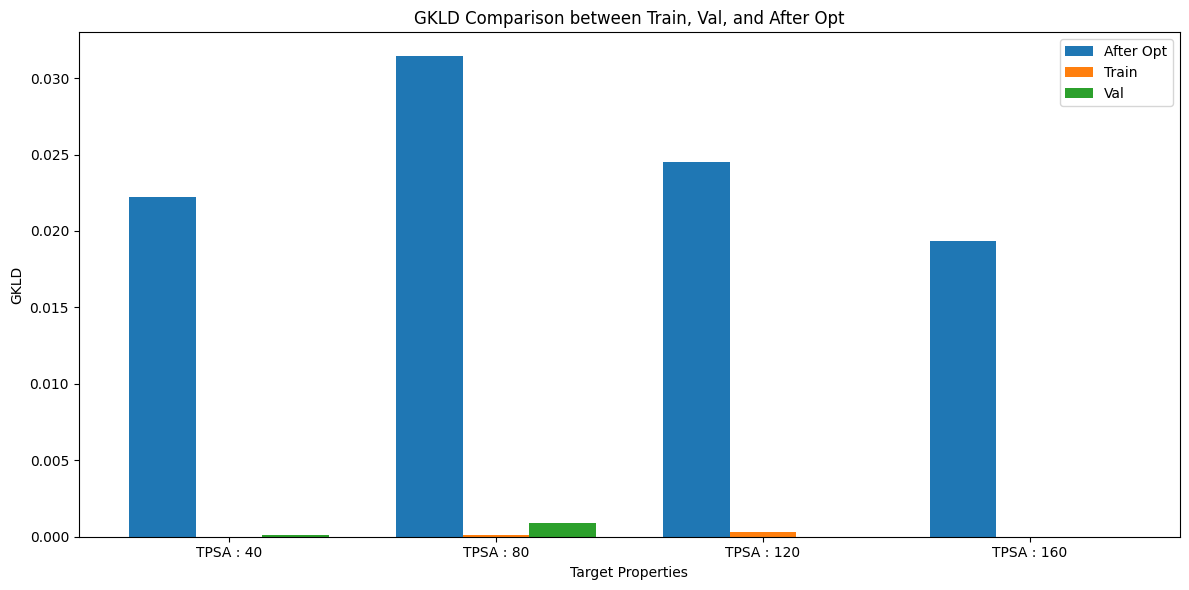

In [25]:
selected_files = [f'val-tpsa-{tpsa}-scaffold.csv' for tpsa in [40, 80, 120, 160]]
labels = [f'TPSA : {tpsa}' for tpsa in [40, 80, 120, 160]]
visualize_gkld_results(gklb, selected_files, labels)

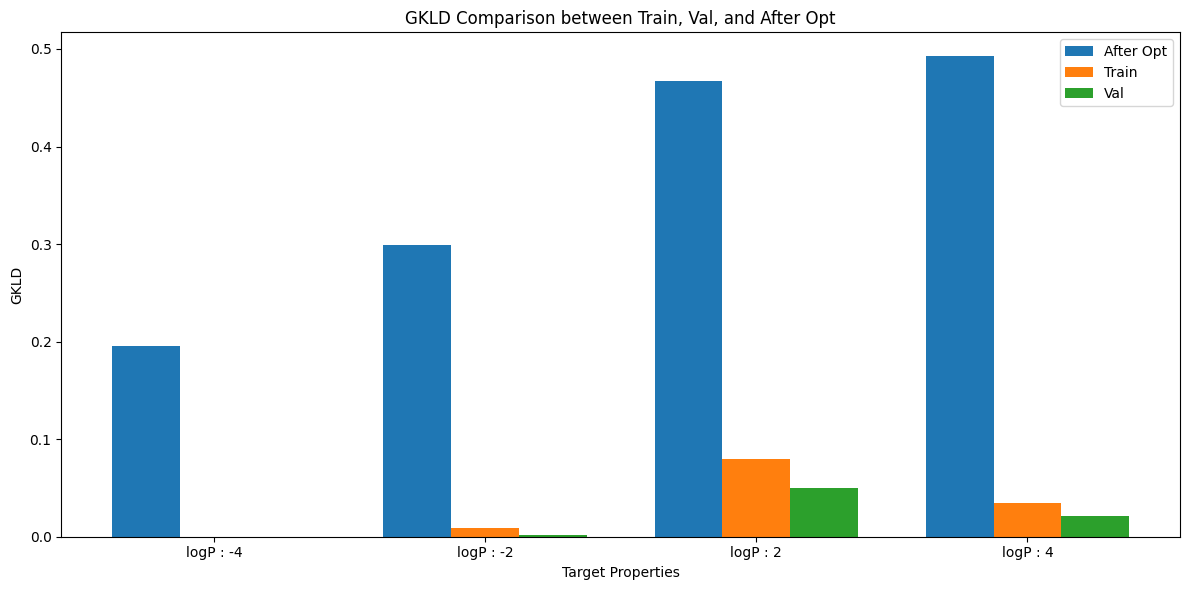

In [28]:
selected_files = [f'val-logp-{logp}-scaffold.csv' for logp in ['n4', 'n2', 2, 4]]
labels = [f'logP : {logp}' for logp in [-4, -2, 2, 4]]
visualize_gkld_results(gklb, selected_files, labels)

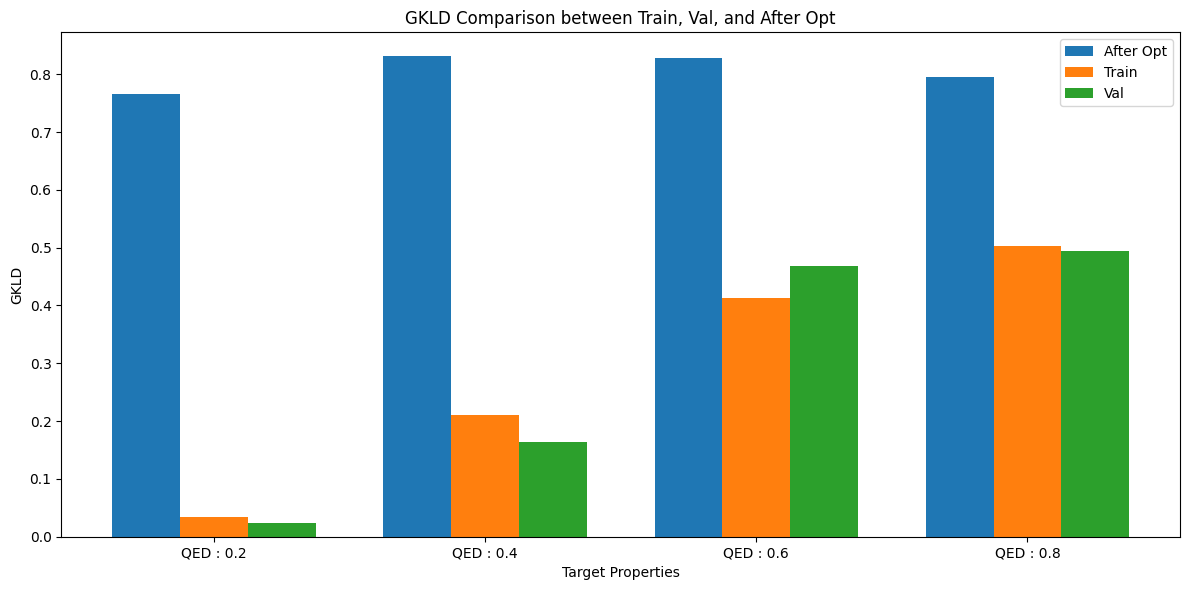

In [33]:
selected_files = [f'val-qed-{qed}-scaffold.csv' for qed in ['0d2', '0d4', '0d6', '0d8']]
labels = [f'QED : {qed}' for qed in [0.2, 0.4, 0.6, 0.8]]
visualize_gkld_results(gklb, selected_files, labels)

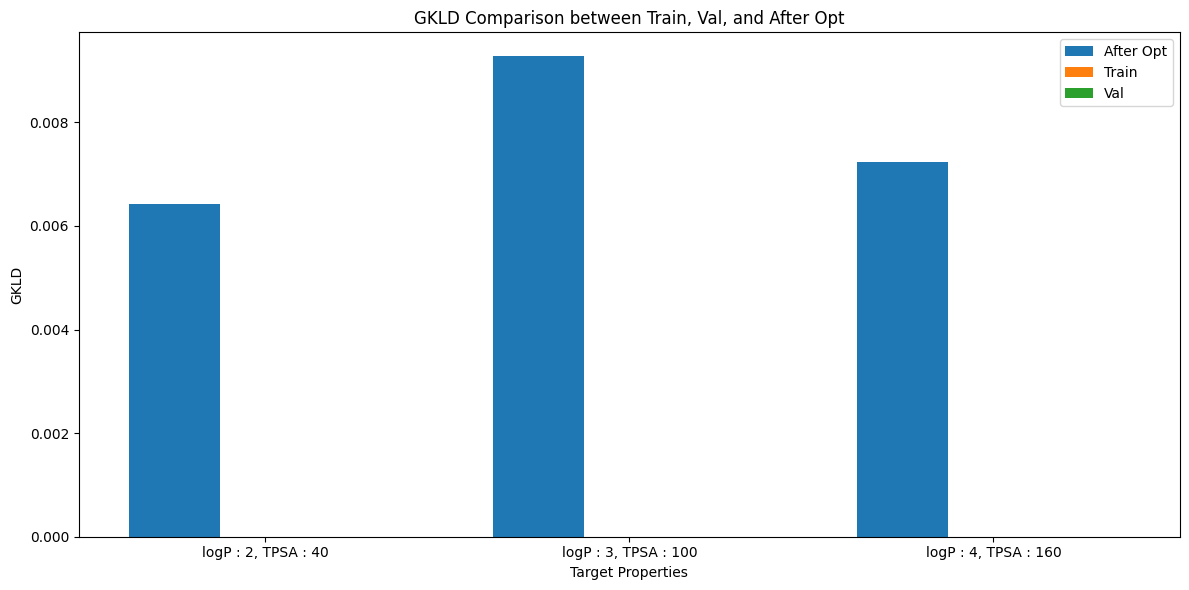

In [31]:
selected_files = ['val-logp-2-tpsa-40-scaffold.csv',
                  'val-logp-3-tpsa-100-scaffold.csv',
                  'val-logp-4-tpsa-160-scaffold.csv',
                  ]
labels = ['logP : 2, TPSA : 40',
          'logP : 3, TPSA : 100',
          'logP : 4, TPSA : 160',
          ]
visualize_gkld_results(gklb, selected_files, labels)

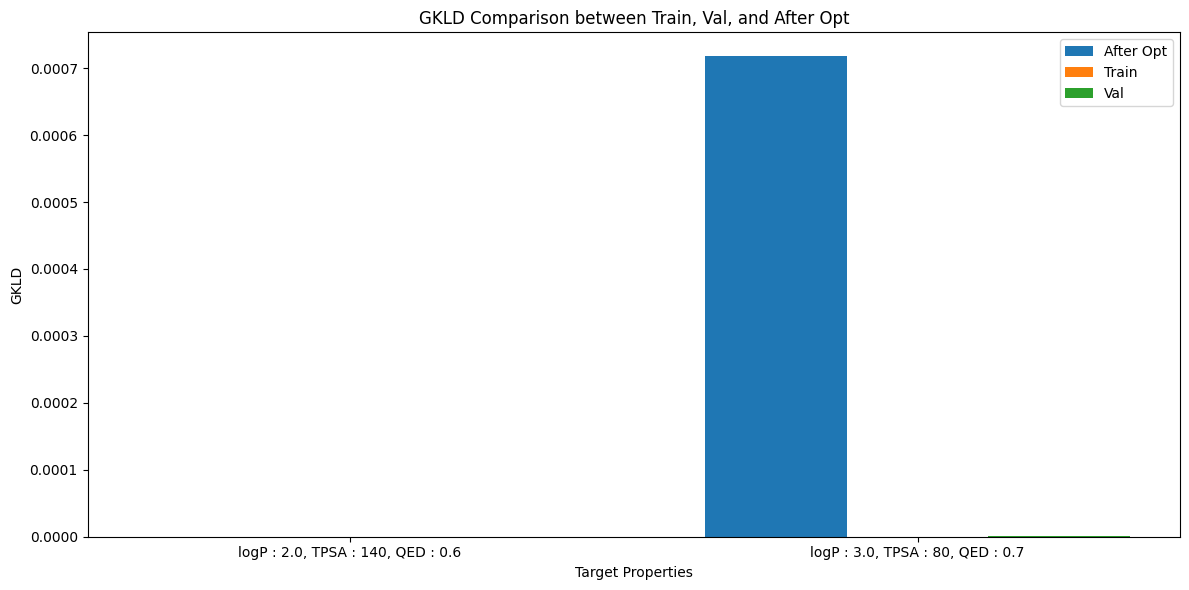

In [32]:
selected_files = ['val-all-logp-250-140-2-0d6-scaffold.csv',
                  'val-all-logp-300-80-3-0d7-scaffold.csv']
labels = ['logP : 2.0, TPSA : 140, QED : 0.6',
            'logP : 3.0, TPSA : 80, QED : 0.7']
visualize_gkld_results(gklb, selected_files, labels)